## Imports

In [1]:
%env TF_FORCE_UNIFIED_MEMORY=1

env: TF_FORCE_UNIFIED_MEMORY=1


In [2]:
import time
import pickle
import models
import utils
import ntk
import plots
import test
import dataset_shapenet1d

from jax import random
from jax import numpy as np

from matplotlib import pyplot as plt
from jax import value_and_grad, grad
from functools import partial
from jax.tree_util import tree_map
import nll
from jax.lax import scan

In [3]:
key = random.PRNGKey(0)

In [4]:
def ci95(array):
    sample_std = np.std(array)
    sample_size = array.shape[0]
    return 0.95 * sample_std / np.sqrt(sample_size)

## Loading simulations

These simulations are not included in the repo (the files are too heavy).
You have to rerun them by yourself, see `readme.md`.
Make sure to save the runs for UNLIMTD-R with `shapenet_random#`, where `#` is the seed of the random matrix (see `vision_unlimtd_r.py`), ranging from `proj_seed=2` to `proj_seed=6`.

In [5]:
with open("logs_final/shapenet_identity.pickle", "rb") as handle:
    output_identity = pickle.load(handle)

In [6]:
with open("logs_final/shapenet_random2.pickle", "rb") as handle:
    output_random2 = pickle.load(handle)

with open("logs_final/shapenet_random3.pickle", "rb") as handle:
    output_random3 = pickle.load(handle)

with open("logs_final/shapenet_random4.pickle", "rb") as handle:
    output_random4 = pickle.load(handle)
    
with open("logs_final/shapenet_random5.pickle", "rb") as handle:
    output_random5 = pickle.load(handle)
    
with open("logs_final/shapenet_random6.pickle", "rb") as handle:
    output_random6 = pickle.load(handle)

In [23]:
with open("logs_final/shapenet_fim.pickle", "rb") as handle:
    output_fim = pickle.load(handle)

In [37]:
with open("logs_final/shapenet_maml_20.pickle", "rb") as handle:
    output_maml = pickle.load(handle)

In [9]:
model = models.deep_network(2, True)
apply_fn = utils.apply_fn_wrapper(model.apply, True)

In [10]:
kernel_identity, kernel_self_identity, jac_identity = ntk.get_kernel_and_jac_identity_cov(apply_fn, output_identity["intermediate_params"], output_identity["intermediate_batch_stats"])
kernel_random2, kernel_self_random2, jac_random2 = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, output_random2["trained_params"], output_random2["trained_scale"], output_random2["trained_batch_stats"], output_random2["proj"])
kernel_random3, kernel_self_random3, jac_random3 = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, output_random3["trained_params"], output_random3["trained_scale"], output_random3["trained_batch_stats"], output_random3["proj"])
kernel_random4, kernel_self_random4, jac_random4 = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, output_random4["trained_params"], output_random4["trained_scale"], output_random4["trained_batch_stats"], output_random4["proj"])
kernel_random5, kernel_self_random5, jac_random5 = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, output_random5["trained_params"], output_random5["trained_scale"], output_random5["trained_batch_stats"], output_random5["proj"])
kernel_random6, kernel_self_random6, jac_random6 = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, output_random6["trained_params"], output_random6["trained_scale"], output_random6["trained_batch_stats"], output_random6["proj"])
kernel_fim, kernel_self_fim, jac_fim = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, output_fim["trained_params"], output_fim["trained_scale"], output_fim["trained_batch_stats"], output_fim["proj"])

In [11]:
dataset_shapenet1d.load_shapenet1d()

Loading training dataset
Training ataset ready
Loading val dataset
Loaded val dataset
Loading test dataset
Loaded test dataset


## Prediction examples with FIM

In [21]:
plt.gray()

<Figure size 432x288 with 0 Axes>

In [22]:
query_indexes = np.arange(15, 25) #has to be greater than 15

In [24]:
def do_prediction(x_a, y_a, x_b):
    y_acorr = y_a - utils.falseaffine_correction0(jac_fim, output_fim["trained_mean"], x_a)
    predictions = nll.gaussian_posterior(kernel_fim, kernel_self_fim, x_a, y_acorr, x_b, 0.01)
    predictions = predictions + utils.falseaffine_correction0(jac_fim, output_fim["trained_mean"], x_b)
    pred_angle = np.arctan2(predictions[:, 1], predictions[:, 0])
    pred_angle = np.where(pred_angle < 0 , 2*np.pi + pred_angle, pred_angle)
    return pred_angle

In [27]:
def plot_predictions(task_index, query_indexes):
    x_a = dataset_shapenet1d.x_test[task_index, :15]
    y_a = dataset_shapenet1d.y_test[task_index, :15, 0:2]
    
    for query_index in query_indexes:
        x_b = dataset_shapenet1d.x_test[task_index, query_index:query_index+1]
        y_b = dataset_shapenet1d.y_test[task_index, query_index:query_index+1, 2]
        
        pred = do_prediction(x_a, y_a, x_b)
        
        print("\n\n")
        plt.imshow(x_b[0])
        plt.show()
        print(f"True angle: {(y_b[0] * 360)/(2 * np.pi):.2f}")
        print(f"Pred angle: {(pred[0] * 360)/(2 * np.pi):.2f}")
        print("\n\n")

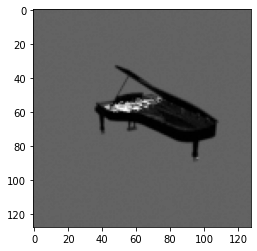

True angle: 200.00
Pred angle: 206.71








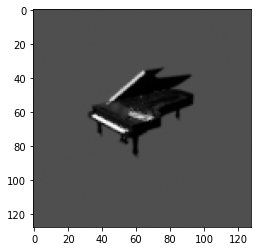

True angle: 102.00
Pred angle: 99.81








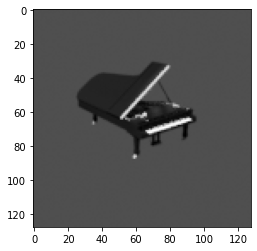

True angle: 11.00
Pred angle: 11.10








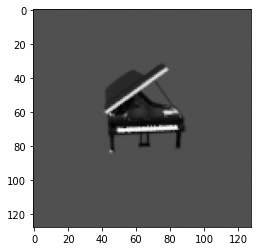

True angle: 43.00
Pred angle: 22.69








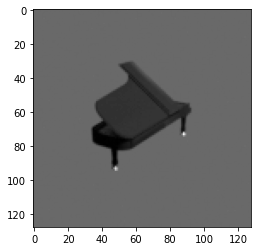

True angle: 263.00
Pred angle: 264.28








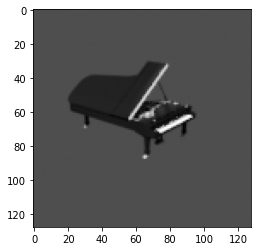

True angle: 359.00
Pred angle: 352.61








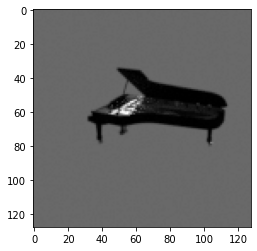

True angle: 168.00
Pred angle: 166.33








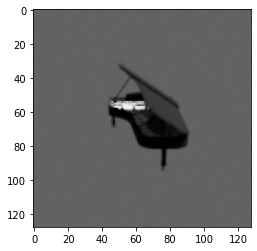

True angle: 228.00
Pred angle: 236.39








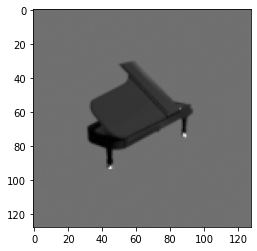

True angle: 267.00
Pred angle: 262.46








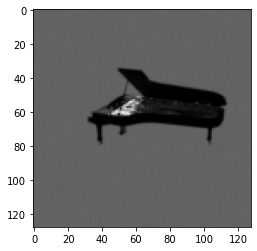

True angle: 165.00
Pred angle: 167.46





In [28]:
plot_predictions(1, query_indexes)

## Angle error

In [16]:
def mse_f_K(key, min_K, max_K):
    Ks = range(min_K, max_K)
    mses_fim_train = []
    mses_fim_val = []
    mses_fim_test = []
    mses_random_train = []
    mses_random_val = []
    mses_random_test = []
    mses_identity_train = []
    mses_identity_val = []
    mses_identity_test = []
    
    ci95s_fim_train = []
    ci95s_fim_val = []
    ci95s_fim_test = []
    ci95s_random_train = []
    ci95s_random_val = []
    ci95s_random_test = []
    ci95s_identity_train = []
    ci95s_identity_val = []
    ci95s_identity_test = []
    
    for K in Ks:
        print(f"Computation for K={K}")
        key, subkey_1 = random.split(key)
        
        mse_identity_train = test.test_error_one_kernel(key, kernel_identity, kernel_self_identity, jac_identity, dataset_shapenet1d.get_train_batch_as_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_identity["intermediate_mean"])
        mse_identity_val = test.test_error_one_kernel(key, kernel_identity, kernel_self_identity, jac_identity, dataset_shapenet1d.get_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_identity["intermediate_mean"])
        mse_identity_test = test.test_error_one_kernel(key, kernel_identity, kernel_self_identity, jac_identity, dataset_shapenet1d.get_test_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_identity["intermediate_mean"])

        mse_random2_train = test.test_error_one_kernel(key, kernel_random2, kernel_self_random2, jac_random2, dataset_shapenet1d.get_train_batch_as_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random2["trained_mean"])
        mse_random2_val = test.test_error_one_kernel(key, kernel_random2, kernel_self_random2, jac_random2, dataset_shapenet1d.get_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random2["trained_mean"])
        mse_random2_test = test.test_error_one_kernel(key, kernel_random2, kernel_self_random2, jac_random2, dataset_shapenet1d.get_test_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random2["trained_mean"])
        mse_random3_train = test.test_error_one_kernel(key, kernel_random3, kernel_self_random3, jac_random3, dataset_shapenet1d.get_train_batch_as_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random3["trained_mean"])
        mse_random3_val = test.test_error_one_kernel(key, kernel_random3, kernel_self_random3, jac_random3, dataset_shapenet1d.get_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random3["trained_mean"])
        mse_random3_test = test.test_error_one_kernel(key, kernel_random3, kernel_self_random3, jac_random3, dataset_shapenet1d.get_test_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random3["trained_mean"])
        mse_random4_train = test.test_error_one_kernel(key, kernel_random4, kernel_self_random4, jac_random4, dataset_shapenet1d.get_train_batch_as_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random4["trained_mean"])
        mse_random4_val = test.test_error_one_kernel(key, kernel_random4, kernel_self_random4, jac_random4, dataset_shapenet1d.get_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random4["trained_mean"])
        mse_random4_test = test.test_error_one_kernel(key, kernel_random4, kernel_self_random4, jac_random4, dataset_shapenet1d.get_test_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random4["trained_mean"])
        mse_random5_train = test.test_error_one_kernel(key, kernel_random5, kernel_self_random5, jac_random5, dataset_shapenet1d.get_train_batch_as_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random5["trained_mean"])
        mse_random5_val = test.test_error_one_kernel(key, kernel_random5, kernel_self_random5, jac_random5, dataset_shapenet1d.get_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random5["trained_mean"])
        mse_random5_test = test.test_error_one_kernel(key, kernel_random5, kernel_self_random5, jac_random5, dataset_shapenet1d.get_test_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random5["trained_mean"])
        mse_random6_train = test.test_error_one_kernel(key, kernel_random6, kernel_self_random6, jac_random6, dataset_shapenet1d.get_train_batch_as_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random6["trained_mean"])
        mse_random6_val = test.test_error_one_kernel(key, kernel_random6, kernel_self_random6, jac_random6, dataset_shapenet1d.get_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random6["trained_mean"])
        mse_random6_test = test.test_error_one_kernel(key, kernel_random6, kernel_self_random6, jac_random6, dataset_shapenet1d.get_test_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_random6["trained_mean"])

        mse_fim_train = test.test_error_one_kernel(key, kernel_fim, kernel_self_fim, jac_fim, dataset_shapenet1d.get_train_batch_as_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_fim["trained_mean"])
        mse_fim_val = test.test_error_one_kernel(key, kernel_fim, kernel_self_fim, jac_fim, dataset_shapenet1d.get_val_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_fim["trained_mean"])
        mse_fim_test = test.test_error_one_kernel(key, kernel_fim, kernel_self_fim, jac_fim, dataset_shapenet1d.get_test_batch, dataset_shapenet1d.error_fn, K, 15, 100, 0, 0.01, output_fim["trained_mean"])

        mses_identity_train.append(np.mean(mse_identity_train))
        ci95s_identity_train.append(ci95(mse_identity_train))
        
        mses_identity_val.append(np.mean(mse_identity_val))
        ci95s_identity_val.append(ci95(mse_identity_val))
        
        mses_identity_test.append(np.mean(mse_identity_test))
        ci95s_identity_test.append(ci95(mse_identity_test))
        
        mses_fim_train.append(np.mean(mse_fim_train))
        ci95s_fim_train.append(ci95(mse_fim_train))
        
        mses_fim_val.append(np.mean(mse_fim_val))
        ci95s_fim_val.append(ci95(mse_fim_val))
        
        mses_fim_test.append(np.mean(mse_fim_test))
        ci95s_fim_test.append(ci95(mse_fim_test))
        
        mse_random_train_all = np.concatenate( (mse_random2_train, mse_random3_train, mse_random4_train, mse_random5_train, mse_random6_train) )
        mses_random_train.append(np.mean(mse_random_train_all))
        ci95s_random_train.append(ci95(mse_random_train_all))
        
        mse_random_val_all = np.concatenate( (mse_random2_val, mse_random3_val, mse_random4_val, mse_random5_val, mse_random6_val) )
        mses_random_val.append(np.mean(mse_random_val_all))
        ci95s_random_val.append(ci95(mse_random_val_all))
        
        mse_random_test_all = np.concatenate( (mse_random2_test, mse_random3_test, mse_random4_test, mse_random5_test, mse_random6_test) )
        mses_random_test.append(np.mean(mse_random_test_all))
        ci95s_random_test.append(ci95(mse_random_test_all))

    return Ks, np.array(mses_identity_train), np.array(ci95s_identity_train), np.array(mses_identity_val), np.array(ci95s_identity_val), np.array(mses_identity_test), np.array(ci95s_identity_test), np.array(mses_fim_train), np.array(ci95s_fim_train), np.array(mses_fim_val), np.array(ci95s_fim_val), np.array(mses_fim_test), np.array(ci95s_fim_test), np.array(mses_random_train), np.array(ci95s_random_train), np.array(mses_random_val), np.array(ci95s_random_val), np.array(mses_random_test), np.array(ci95s_random_test)

In [17]:
Ks, mses_identity_train, ci95s_identity_train, mses_identity_val, ci95s_identity_val, mses_identity_test, ci95s_identity_test, mses_fim_train, ci95s_fim_train, mses_fim_val, ci95s_fim_val, mses_fim_test, ci95s_fim_test, mses_random_train, ci95s_random_train, mses_random_val, ci95s_random_val, mses_random_test, ci95s_random_test = mse_f_K(key, 1, 16)

Computation for K=1


### MAML
Copy-paste from maml_shapenet

In [28]:
inner_lr = output_maml["config"]["inner_lr"]

In [29]:
def get_train_batch_fn(key, n_tasks, K, L):
    # return sine_dataset.get_test_batch(key, config["n_tasks_per_epoch"], config["K"], config["L"], config["data_noise"])
    # return shapenet_dataset.get_maml_train_batch(key, config["n_tasks_per_epoch"], config["K"], config["L"], config["data_noise"])
    
    # context: cos and sin (for fast adapt)
    # query: cos and sin (to compute outer loss)
    x_a, y_a, x_b, y_b = dataset_shapenet1d.get_maml_train_batch(key, n_tasks, K, L, 0)
    return x_a, y_a, x_b, y_b[:, :, 0:2]

def get_train_batch_as_val_batch_fn(key, n_tasks, K, L):
    # return sine_dataset.get_test_batch(key, config["n_test_tasks"], config["K"], config["L"], config["data_noise"])
    # return shapenet_dataset.get_test_batch(key, config["n_test_tasks"], config["K"], config["L"], config["data_noise"])
    # return shapenet_dataset.get_maml_train_batch(key, config["n_tasks_per_epoch"], config["K"], config["L"], config["data_noise"])
    
    # context: cos and sin (for fast adapt)
    # query: angle (just to compare, because no outer loss here)
    x_a, y_a, x_b, y_b = dataset_shapenet1d.get_maml_train_batch(key, n_tasks, K, L, 0)
    return x_a, y_a, x_b, y_b[:, :, 2]

def get_val_batch_fn(key, n_tasks, K, L):
    # return sine_dataset.get_test_batch(key, config["n_test_tasks"], config["K"], config["L"], config["data_noise"])
    # return shapenet_dataset.get_test_batch(key, config["n_test_tasks"], config["K"], config["L"], config["data_noise"])
    # return shapenet_dataset.get_maml_train_batch(key, config["n_tasks_per_epoch"], config["K"], config["L"], config["data_noise"])
    
    # context: cos and sin (for fast adapt)
    # query: angle (just to compare, because no outer loss here)
    x_a, y_a, x_b, y_b = dataset_shapenet1d.get_maml_val_batch(key, n_tasks, K, L, 0)
    return x_a, y_a, x_b, y_b[:, :, 2]

def get_test_batch_fn(key, n_tasks, K, L):
    # return sine_dataset.get_test_batch(key, config["n_test_tasks"], config["K"], config["L"], config["data_noise"])
    # return shapenet_dataset.get_test_batch(key, config["n_test_tasks"], config["K"], config["L"], config["data_noise"])
    # return shapenet_dataset.get_maml_train_batch(key, config["n_tasks_per_epoch"], config["K"], config["L"], config["data_noise"])
    
    # context: cos and sin (for fast adapt)
    # query: angle (just to compare, because no outer loss here)
    x_a, y_a, x_b, y_b = dataset_shapenet1d.get_maml_test_batch(key, n_tasks, K, L, 0)
    return x_a, y_a, x_b, y_b[:, :, 2]

In [30]:
model = models.deep_network(2, True)

def apply_fn(params, inputs):
    return model.apply({"params": params}, inputs, mutable=["batch_stats"])[0]

key, key_init0, key_init1 = random.split(key, 3)
batch = get_train_batch_fn(key_init0, 10, 15, 15)
init_vars = model.init(key_init1, batch[0][0])

In [31]:
def error_fn_train(pred_cos_sin, gt_cos_sin):
    # shape of cos_sin_pred / cos_sin_gt is (batch_size, 2)
    tmp = np.sum((pred_cos_sin - gt_cos_sin)**2, axis = 1)
    return np.mean(tmp)

def angle_error(gd_angle, pred_angle):
    error_a = np.abs(pred_angle + 2 * np.pi - gd_angle)[:, np.newaxis]
    error_b = np.abs(pred_angle - 2 * np.pi - gd_angle)[:, np.newaxis]
    error_c = np.abs(pred_angle - gd_angle)[:, np.newaxis]
    
    errors = np.concatenate( (error_a, error_b, error_c), axis=1 )
    
    return errors.min(axis=1)

def error_fn_test(pred_cos_sin, gt_angle):
    pred_angle = np.arctan2(pred_cos_sin[:, 1], pred_cos_sin[:, 0])
    pred_angle = np.where(pred_angle < 0 , 2*np.pi + pred_angle, pred_angle)
    angle_errors =  angle_error(gt_angle, pred_angle)
    
    # returns the average for this batch (in degrees!)
    return 360 * np.mean(angle_errors) / (2 * np.pi)

In [32]:
def inner_loss(current_params, x_a, y_a, apply_fn):
    predictions = apply_fn(current_params, x_a)
    
    return error_fn_train(predictions, y_a)

def gd_step0(inner_lr, param_value, param_grad):
    return param_value - inner_lr * param_grad

def inner_updates(current_params, x_a, y_a, n_updates, inner_lr, apply_fn):
    def f(parameters, x):
        inner_gradients = grad(inner_loss)(parameters, x_a, y_a, apply_fn)
        parameters = tree_map(partial(gd_step0, inner_lr), parameters, inner_gradients)
        
        return parameters, None
    
    updated_params, _ = scan(f, current_params, None, n_updates)
    
    return updated_params

In [33]:
def do_test(params, n_updates_test, x_a, y_a, x_b, y_b):
    def f(carry, task):
        x_a, y_a, x_b, y_b = task
        
        updated_params = inner_updates(params, x_a, y_a, n_updates_test, inner_lr, apply_fn)
        predictions = apply_fn(updated_params, x_b)
        
        return None, error_fn_test(predictions, y_b)
    
    _, errors = scan(f, None, (x_a, y_a, x_b, y_b))
    return errors

def test_maml(key, params, K, n_updates_test):
    x_a, y_a, x_b, y_b = get_train_batch_as_val_batch_fn(key, 100, K, 15)
    error_train = do_test(params, n_updates_test, x_a, y_a, x_b, y_b)
    
    x_a, y_a, x_b, y_b = get_val_batch_fn(key, 100, K, 15)
    error_val = do_test(params, n_updates_test, x_a, y_a, x_b, y_b)
    
    x_a, y_a, x_b, y_b = get_test_batch_fn(key, 100, K, 15)
    error_test = do_test(params, n_updates_test, x_a, y_a, x_b, y_b)
    
    return (error_train, error_val, error_test)

In [34]:
def error_f_K_MAML(key, min_K, max_K):
    Ks = range(min_K, max_K)
    
    errors_maml20_train = []
    errors_maml20_val = []
    errors_maml20_test = []
    ci95s_maml20_train = []
    ci95s_maml20_val = []
    ci95s_maml20_test = []
    
    for K in Ks:
        print(f"Computation for K={K}")
        key, subkey1 = random.split(key)
        
        error_maml20_train, error_maml20_val, error_maml20_test = test_maml(subkey1, output_maml["trained_params"], K, n_updates_test=20)
        
        errors_maml20_train.append(np.mean(error_maml20_train))
        ci95s_maml20_train.append(ci95(error_maml20_train))
        errors_maml20_val.append(np.mean(error_maml20_val))
        ci95s_maml20_val.append(ci95(error_maml20_val))
        errors_maml20_test.append(np.mean(error_maml20_test))
        ci95s_maml20_test.append(ci95(error_maml20_test))

    return Ks, np.array(errors_maml20_train), np.array(ci95s_maml20_train), np.array(errors_maml20_val), np.array(ci95s_maml20_val), np.array(errors_maml20_test), np.array(ci95s_maml20_test)

In [35]:
Ks, errors_maml20_train, ci95s_maml20_train, errors_maml20_val, ci95s_maml20_val, errors_maml20_test, ci95s_maml20_test = error_f_K_MAML(key, 1, 16)

Computation for K=1


### Plots

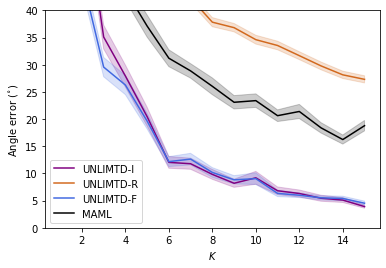

In [30]:
plt.plot(Ks, mses_identity_test, "purple", label="UNLIMTD-I")
plt.fill_between(Ks, mses_identity_test - ci95s_identity_test, mses_identity_test + ci95s_identity_test, color="purple", alpha=0.2)
plt.plot(Ks, mses_random_test, "chocolate", label="UNLIMTD-R")
plt.fill_between(Ks, mses_random_test - ci95s_random_test, mses_random_test + ci95s_random_test, color="chocolate", alpha=0.2)
plt.plot(Ks, mses_fim_test, "royalblue", label="UNLIMTD-F")
plt.fill_between(Ks, mses_fim_test - ci95s_fim_test, mses_fim_test + ci95s_fim_test, color="royalblue", alpha=0.2)
plt.plot(Ks, errors_maml20_test, "k", label="MAML")
plt.fill_between(Ks, errors_maml20_test - ci95s_maml20_test, errors_maml20_test + ci95s_maml20_test, color="k", alpha=0.2)
plt.legend()
plt.gca().set_ylim([0, 40])

plt.gca().set_xlabel("$K$")
plt.gca().set_ylabel("Angle error ($^{\circ}$)")
plt.legend()
plt.savefig("plots/vision_cc.pdf", bbox_inches='tight')

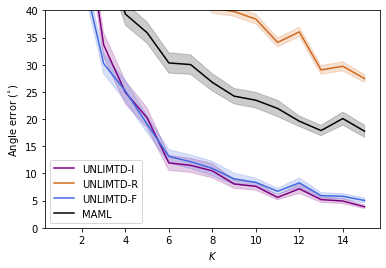

In [32]:
plt.plot(Ks, mses_identity_val, "purple", label="UNLIMTD-I")
plt.fill_between(Ks, mses_identity_val - ci95s_identity_val, mses_identity_val + ci95s_identity_val, color="purple", alpha=0.2)
plt.plot(Ks, mses_random_val, "chocolate", label="UNLIMTD-R")
plt.fill_between(Ks, mses_random_val - ci95s_random_val, mses_random_val + ci95s_random_val, color="chocolate", alpha=0.2)
plt.plot(Ks, mses_fim_val, "royalblue", label="UNLIMTD-F")
plt.fill_between(Ks, mses_fim_val - ci95s_fim_val, mses_fim_val + ci95s_fim_val, color="royalblue", alpha=0.2)
plt.plot(Ks, errors_maml20_val, "k", label="MAML")
plt.fill_between(Ks, errors_maml20_val - ci95s_maml20_val, errors_maml20_val + ci95s_maml20_val, color="k", alpha=0.2)
plt.legend()
plt.gca().set_ylim([0, 40])

plt.gca().set_xlabel("$K$")
plt.gca().set_ylabel("Angle error ($^{\circ}$)")
plt.legend()
plt.savefig("plots/vision_ic.pdf", bbox_inches='tight')

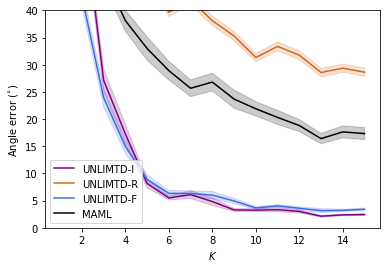

In [33]:
plt.plot(Ks, mses_identity_train, "purple", label="UNLIMTD-I")
plt.fill_between(Ks, mses_identity_train - ci95s_identity_train, mses_identity_train + ci95s_identity_train, color="purple", alpha=0.2)
plt.plot(Ks, mses_random_train, "chocolate", label="UNLIMTD-R")
plt.fill_between(Ks, mses_random_train - ci95s_random_train, mses_random_train + ci95s_random_train, color="chocolate", alpha=0.2)
plt.plot(Ks, mses_fim_train, "royalblue", label="UNLIMTD-F")
plt.fill_between(Ks, mses_fim_train - ci95s_fim_train, mses_fim_train + ci95s_fim_train, color="royalblue", alpha=0.2)
plt.plot(Ks, errors_maml20_train, "k", label="MAML")
plt.fill_between(Ks, errors_maml20_train - ci95s_maml20_train, errors_maml20_train + ci95s_maml20_train, color="k", alpha=0.2)
plt.legend()
plt.gca().set_ylim([0, 40])

plt.gca().set_xlabel("$K$")
plt.gca().set_ylabel("Angle error ($^{\circ}$)")
plt.legend()
plt.savefig("plots/vision_train.pdf", bbox_inches='tight')